In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset3/DATASET3/class 0/20051020_57967_0100_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_58888_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_59916_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_60740_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_55160_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051201_37362_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_54956_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051020_64703_0100_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_60186_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_59793_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_55393_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_55037_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051020_44261_0100_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051020_62510_0100_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_54616_0400_PP

In [2]:
import numpy as np
import pandas as pd
import os

# 📂 List files and validate dataset mount
print("📂 Listing all files under /kaggle/input...\n")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:  # Limit output to first 5 files
        print(os.path.join(dirname, filename))  # ✅ THIS LINE MUST BE INDENTED

# Define dataset path
dataset_path = "/kaggle/input/dataset3/DATASET3"
if not os.path.exists(dataset_path):
    raise FileNotFoundError("❌ Dataset not found! Please click 'Add Data' on the left and attach 'anithajaikumar/dataset3'.")

print("\n✅ Found dataset3 folder! Contents:")
print(os.listdir(dataset_path))

# Set this as your base directory and image resize target
base_dir = dataset_path
target_size = (224, 224)


📂 Listing all files under /kaggle/input...

/kaggle/input/dataset3/DATASET3/class 0/20051020_57967_0100_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_58888_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_59916_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_60740_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 0/20051130_55160_0400_PP.tif
/kaggle/input/dataset3/DATASET3/class 2/20060412_51677_0200_PP.tif
/kaggle/input/dataset3/DATASET3/class 2/20051214_40719_0100_PP.tif
/kaggle/input/dataset3/DATASET3/class 2/20060412_58287_0200_PP.tif
/kaggle/input/dataset3/DATASET3/class 2/20060411_59638_0200_PP.tif
/kaggle/input/dataset3/DATASET3/class 2/20060412_52194_0200_PP.tif
/kaggle/input/dataset3/DATASET3/class 3/20051020_44349_0100_PP.tif
/kaggle/input/dataset3/DATASET3/class 3/20051020_62337_0100_PP.tif
/kaggle/input/dataset3/DATASET3/class 3/20051214_51811_0100_PP.tif
/kaggle/input/dataset3/DATASET3/class 3/20051214_56169_0100_PP.tif
/kaggle/input/data

In [3]:
import os

# Path to your actual class folders
dataset_root = "/kaggle/input/dataset3/DATASET3"

# Count total files across all class folders
total_files = 0
for folder in os.listdir(dataset_root):
    folder_path = os.path.join(dataset_root, folder)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"{folder}: {num_files} files")
        total_files += num_files

print(f"\n✅ Total files found: {total_files}")



class 0: 120 files
class 2: 120 files
class 3: 120 files
class 1: 101 files

✅ Total files found: 461


In [4]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Conv2D, UpSampling2D, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2 as cv
from skimage import exposure
import pandas as pd

2025-07-21 16:41:10.736187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753116070.956637      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753116071.025439      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
from skimage import exposure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

def load_and_preprocess_data(base_dir, target_size, augment=False):
    # Initialize ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if augment else None

    data = []
    labels = []
    class_counts = {}

    for class_folder in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
        
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png','.tif'))]
        class_counts[class_folder] = {'original': len(files), 'augmented': 0}
        max_augment = len(files) * 2  # Double the dataset size per class if augment=True

        for filename in files:
            img_path = os.path.join(class_path, filename)
            img = cv.imread(img_path)

            if img is None:
                continue

            # Resize image
            img = cv.resize(img, target_size)

            # Convert to grayscale
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            # Background removal using GrabCut
            mask = np.zeros(img_gray.shape[:2], np.uint8)
            bgdModel = np.zeros((1, 65), np.float64)
            fgdModel = np.zeros((1, 65), np.float64)
            rect = (10, 10, img_gray.shape[1] - 20, img_gray.shape[0] - 20)
            cv.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)
            mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
            img_cut = img_gray * mask2

            # Histogram Equalization
            img_eq = exposure.equalize_adapthist(img_cut, clip_limit=0.03)
            img_eq = (img_eq * 255).astype(np.uint8)

            # Denoising
            denoised_img = cv.fastNlMeansDenoising(img_eq, None, 10, 7, 21)

            # Convert grayscale to RGB
            img_preprocessed = cv.cvtColor(denoised_img, cv.COLOR_GRAY2RGB)

            # Append original image
            data.append(img_preprocessed)
            labels.append(class_folder)

            # Perform augmentation if enabled
            if augment and class_counts[class_folder]['augmented'] < max_augment - len(files):
                img_aug = img_preprocessed.reshape((1,) + img_preprocessed.shape)
                for x in datagen.flow(img_aug, batch_size=1):
                    data.append(x[0].astype(np.uint8))
                    labels.append(class_folder)
                    class_counts[class_folder]['augmented'] += 1
                    if class_counts[class_folder]['augmented'] >= max_augment - len(files):
                        break

    # Convert to numpy arrays and shuffle
    data = np.array(data, dtype=np.uint8)
    labels = np.array(labels)
    data, labels = shuffle(data, labels, random_state=42)

    return data, labels, class_counts

# Load data
base_dir = "/kaggle/input/dataset3/DATASET3"
target_size = (224, 224)
features, labels, class_counts = load_and_preprocess_data(base_dir, target_size, augment=True)

# Label encoding
label_mapping = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels_encoded = np.array([label_mapping[label] for label in labels])
labels_one_hot = tf.keras.utils.to_categorical(labels_encoded)

print(f"Data shape: {features.shape}")
print(f"Labels shape: {labels_one_hot.shape}")
print(f"Class distribution: {class_counts}")


Data shape: (922, 224, 224, 3)
Labels shape: (922, 4)
Class distribution: {'class 0': {'original': 120, 'augmented': 120}, 'class 1': {'original': 101, 'augmented': 101}, 'class 2': {'original': 120, 'augmented': 120}, 'class 3': {'original': 120, 'augmented': 120}}


In [7]:
# Create a TensorFlow dataset from features and labels
data_ds = tf.data.Dataset.from_tensor_slices((features, labels_one_hot))

# Function to split into train, validation, and test sets
def split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    assert train_split + val_split + test_split == 1.0, "Splits must sum to 1."
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

# Split the dataset
train_ds, val_ds, test_ds = split(data_ds)

# Dataset optimization: batching, caching, shuffling, and prefetching
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)


I0000 00:00:1753116362.153808      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
len(val_ds)

3

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Concatenate, UpSampling2D,
                                     GlobalAveragePooling2D, Dense)
from tensorflow.keras.optimizers import Adam

# Load the EfficientNetB0 base model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract feature maps from key stages for FPN (C3, C4, C5)
c3_output = base_model.get_layer('block3a_expand_activation').output  # Lower-level features
c4_output = base_model.get_layer('block4a_expand_activation').output  # Mid-level features
c5_output = base_model.get_layer('block6a_expand_activation').output  # Higher-level features

# FPN top-down pathway and lateral connections
p5 = Conv2D(256, (1, 1), padding='same', activation='relu')(c5_output)
p5_upsampled = UpSampling2D()(p5)

c4_conv = Conv2D(256, (1, 1), padding='same', activation='relu')(c4_output)
p4 = Concatenate()([p5_upsampled, c4_conv])
p4_upsampled = UpSampling2D()(p4)

c3_conv = Conv2D(256, (1, 1), padding='same', activation='relu')(c3_output)
p3 = Concatenate()([p4_upsampled, c3_conv])

# Final feature extraction
p3_output = Conv2D(256, (3, 3), padding='same', activation='relu')(p3)

# Fully connected layers
x = GlobalAveragePooling2D()(p3_output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(len(label_mapping), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model summary (optional)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 3,776,779 (14.41 MB)

 Trainable params: 3,759,268 (14.34 MB)

 Non-trainable params: 17,511 (68.41 KB)

In [15]:
history = model.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.2572 - loss: 1.4661 - val_accuracy: 0.2500 - val_loss: 1.3822
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.3579 - loss: 1.3413 - val_accuracy: 0.2609 - val_loss: 1.4046
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.4500 - loss: 1.1352 - val_accuracy: 0.5109 - val_loss: 1.1046
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.5000 - loss: 0.9940 - val_accuracy: 0.5652 - val_loss: 1.0571
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6461 - loss: 0.8571 - val_accuracy: 0.4130 - val_loss: 1.1282
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6456 - loss: 0.8346 - val_accuracy: 0.5109 - val_loss: 1.1189
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6947 - loss: 0.6988 - val_accuracy: 0.6739 - val_loss: 0.8858
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.8022 - loss: 0.5350 - val_accura

In [16]:
loss, accuracy = model.evaluate(test_ds)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Loss: {loss:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9722 - loss: 0.0982 
Accuracy: 96.77%
Loss: 0.1134


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9722 - loss: 0.0982
test Accuracy: 96.77%
Loss: 0.1134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


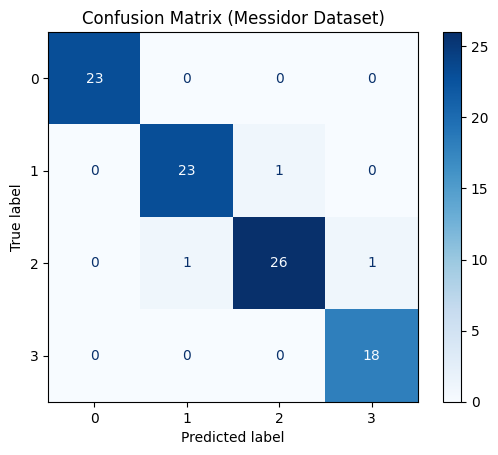

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Evaluate the model on combined dataset (optional)
loss, accuracy = model.evaluate(test_ds)
print(f'test Accuracy: {accuracy * 100:.2f}%')
print(f'Loss: {loss:.4f}')

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # true label
    y_pred.extend(np.argmax(preds, axis=1))           # predicted label

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names
class_names = test_ds.class_names if hasattr(test_ds, 'class_names') else None

# Plot and save confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Messidor Dataset)")
plt.savefig("confusion_matrix_combined.png", dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


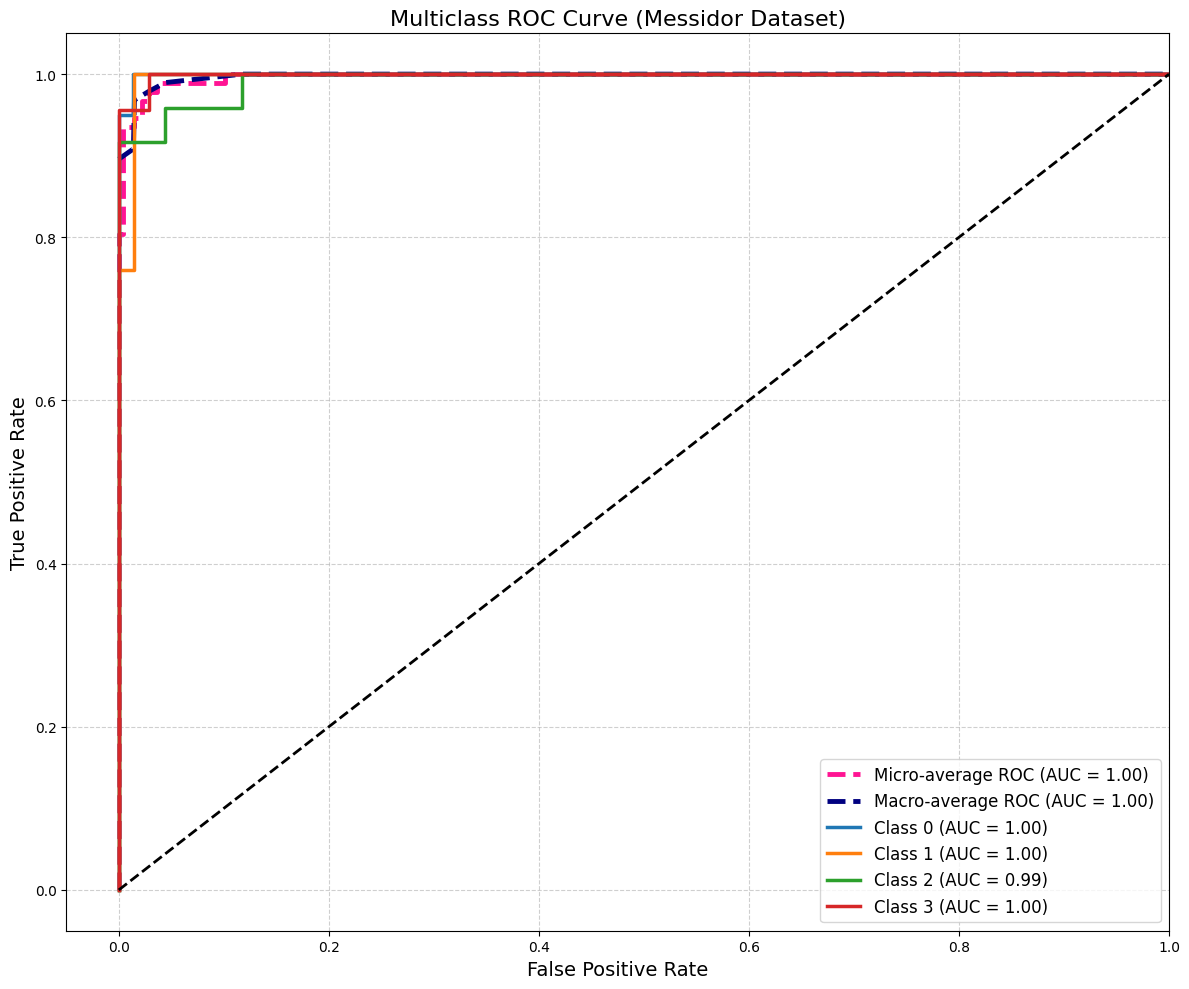

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Step 1: Collect predictions and true labels from val_ds
y_true = []
y_score = []

for images, labels in val_ds:
    preds = model.predict(images)  # shape: (batch_size, num_classes)
    y_score.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

n_classes = y_true.shape[1]
class_names = val_ds.class_names if hasattr(test_ds, 'class_names') else [f"Class {i}" for i in range(n_classes)]

# Step 2: Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Step 4: Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Step 5: Plot
plt.figure(figsize=(12, 10))

# Micro and macro
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle='--', linewidth=3.5)

plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})",
         color='navy', linestyle='--', linewidth=3.5)

# Individual class curves
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Labels and styling
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multiclass ROC Curve (Messidor Dataset)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save and Show

plt.savefig("roc_curve_test_ds.png", dpi=300, bbox_inches='tight')
plt.show()


In [29]:
# Save the entire model (architecture + weights + optimizer state)
model.save("my_model.h5")  # HDF5 format (widely supported)
